In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import contractions
import gensim.downloader as api
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import gensim.models
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import tensorflow as tf
warnings.filterwarnings('ignore')
from keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, Conv2D, MaxPooling2D
from keras import Input
from tensorflow.keras.optimizers import Adam

In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Dataset Generation

In [ ]:
# input_f = "gdrive/MyDrive/Colab Notebooks/amazon_reviews_us_Beauty_v1_00.tsv"
input_f = "amazon_reviews_us_Beauty_v1_00.tsv"
df = pd.read_csv(input_f,sep='\t', error_bad_lines=False, warn_bad_lines=False)
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,1797882,R3I2DHQBR577SS,B001ANOOOE,2102612,The Naked Bee Vitmin C Moisturizing Sunscreen ...,Beauty,5,0.0,0.0,N,Y,Five Stars,"Love this, excellent sun block!!",2015-08-31
1,US,18381298,R1QNE9NQFJC2Y4,B0016J22EQ,106393691,"Alba Botanica Sunless Tanning Lotion, 4 Ounce",Beauty,5,0.0,0.0,N,Y,Thank you Alba Bontanica!,The great thing about this cream is that it do...,2015-08-31
2,US,19242472,R3LIDG2Q4LJBAO,B00HU6UQAG,375449471,"Elysee Infusion Skin Therapy Elixir, 2oz.",Beauty,5,0.0,0.0,N,Y,Five Stars,"Great Product, I'm 65 years old and this is al...",2015-08-31
3,US,19551372,R3KSZHPAEVPEAL,B002HWS7RM,255651889,"Diane D722 Color, Perm And Conditioner Process...",Beauty,5,0.0,0.0,N,Y,GOOD DEAL!,I use them as shower caps & conditioning caps....,2015-08-31
4,US,14802407,RAI2OIG50KZ43,B00SM99KWU,116158747,Biore UV Aqua Rich Watery Essence SPF50+/PA+++...,Beauty,5,0.0,0.0,N,Y,this soaks in quick and provides a nice base f...,This is my go-to daily sunblock. It leaves no ...,2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5087968,US,29399262,R2AEH9L5PCOL0C,B000620OGC,531618700,Avon Advance Techniques Straight & Sleek Dry E...,Beauty,1,1.0,5.0,N,N,Use only if you want Oily feel like hair,I tried this stuff and it made my hair feel oi...,2005-02-03
5087969,US,38881154,R29TN19DCVI44R,B000052YHS,397259610,"Gillette Mach3 Men's Razor, Mens Razors / Blades",Beauty,4,1.0,1.0,N,N,Good but...,This is an extremely good razor. It definitel...,2005-02-03
5087970,US,14626862,R2X1AWYK6MGBE,B0002I3ZNO,833332489,"V'Tae Oatmeal Silk Bath, Healing Therapy, 6-Ou...",Beauty,5,0.0,0.0,N,N,soothing,I bought this because I have extremely dry sen...,2005-02-03
5087971,US,35142523,R1L6C2F1ZB6YKT,B000063XHQ,442263387,Panasonic ER411NC Nose and Ear Hair Groomer,Beauty,5,2.0,9.0,N,N,"embarrassing gift, but great","Buy it for yourself. It's less than $15, and *...",2005-02-03


In [ ]:
## keep the reviews and rating fields in the input data frame
reviews = df[['star_rating', 'review_body']]
reviews

,star_rating,review_body
0,5,"Love this, excellent sun block!!"
1,5,The great thing about this cream is that it do...
2,5,"Great Product, I'm 65 years old and this is al..."
3,5,I use them as shower caps & conditioning caps....
4,5,This is my go-to daily sunblock. It leaves no ...
...,...,...
5087968,1,I tried this stuff and it made my hair feel oi...
5087969,4,This is an extremely good razor. It definitel...
5087970,5,I bought this because I have extremely dry sen...
5087971,5,"Buy it for yourself. It's less than $15, and *..."


In [ ]:
## balance dataset with 60k reviews
## finding class 1
class_1_reviews = reviews.loc[(reviews['star_rating'] == 1) | (reviews['star_rating'] == 2)].reset_index(drop = True)
class_1_reviews = class_1_reviews.dropna()
## finding class 2
class_2_reviews = reviews.loc[reviews['star_rating'] == 3].reset_index(drop = True)
class_2_reviews = class_2_reviews.dropna()
## finding class 3
class_3_reviews = reviews.loc[(reviews['star_rating'] == 4) | (reviews['star_rating'] == 5)].reset_index(drop = True)
class_3_reviews = class_3_reviews.dropna()

## randomly select 20,000 for each class 
n = 20000
class_1_select = class_1_reviews.groupby('star_rating', group_keys=False).apply(lambda x: x.sample(10000, random_state = 42))
class_2_select = class_2_reviews.sample(n, replace = False, random_state = 42)
class_3_select = class_3_reviews.groupby('star_rating', group_keys=False).apply(lambda x: x.sample(10000, random_state = 42))

df_all = pd.concat([class_1_select, class_2_select, class_3_select]).reset_index(drop=True)
df_all

,star_rating,review_body
0,1,The product was going to be a gift for my wife...
1,1,Most of the eyelashes werent good to work with...
2,1,"I own a Jessy wig and love it, so I thought I ..."
3,1,Was not good for my hair did not work the way ...
4,1,Don't get this it is not worth the money I got...
...,...,...
59995,5,"Great product, makes hair cutting a breeze and..."
59996,5,With age comes with sagging in my face. This m...
59997,5,I love the glass bottle and the scent. Those w...
59998,5,Bought it for my 12 year-old daughter loved th...


In [ ]:
df_all['star_rating'].unique()

array([1, 2, 3, 4, 5.0], dtype=object)

In [ ]:
## Preprocessing
rev = df_all['review_body']

## convert all reviews into lowercase   
text_lowercase = rev.str.lower()

## remove the HTML and URLs from the reviews
text_notag = []
for item in text_lowercase:
    soup = BeautifulSoup(item, 'html.parser')
    text = soup.get_text()
    text = re.sub(r'https?://\S+', '', text)
    text_notag.append(text)
    
## remove non-alphabetical characters
text_cha = []
for item in text_notag:
    text = re.sub(r"[^a-zA-Z |']", ' ', item)
    text_cha.append(text)
    
## remove extra spaces
text_sp = []
for item in text_cha:
    text = re.sub(' +', ' ', item)
    text_sp.append(text)
        
## perform contractions 
text_con = []
for item in text_sp:
    text = contractions.fix(item)
    text_con.append(text)
       
# ## remove stopwords
# stop_words = set(stopwords.words('english'))
# text_stop = []
# for item in text_con:
#     item_split = item.split()
#     i = ' '.join([word for word in item_split if word not in stop_words])
#     text_stop.append(i)

In [ ]:
df_all['new'] = text_sp

In [ ]:
df_all

,star_rating,review_body,new
0,1,The product was going to be a gift for my wife...,the product was going to be a gift for my wife...
1,1,Most of the eyelashes werent good to work with...,most of the eyelashes werent good to work with...
2,1,"I own a Jessy wig and love it, so I thought I ...",i own a jessy wig and love it so i thought i w...
3,1,Was not good for my hair did not work the way ...,was not good for my hair did not work the way ...
4,1,Don't get this it is not worth the money I got...,don't get this it is not worth the money i got...
...,...,...,...
59995,5,"Great product, makes hair cutting a breeze and...",great product makes hair cutting a breeze and ...
59996,5,With age comes with sagging in my face. This m...,with age comes with sagging in my face this mo...
59997,5,I love the glass bottle and the scent. Those w...,i love the glass bottle and the scent those wh...
59998,5,Bought it for my 12 year-old daughter loved th...,bought it for my year old daughter loved the c...


In [ ]:
class_spe = df_all['star_rating'].astype('int')
for i in range (len(class_spe)):
    if class_spe[i] == 1 or class_spe[i] == 2:
        class_spe[i] = 1
    if class_spe[i] == 3:
        class_spe[i] = 2
    if class_spe[i] == 4 or class_spe[i] == 5:
        class_spe[i] = 3
df_all['class'] = class_spe
df_all

,star_rating,review_body,new,class
0,1,The product was going to be a gift for my wife...,the product was going to be a gift for my wife...,1
1,1,Most of the eyelashes werent good to work with...,most of the eyelashes werent good to work with...,1
2,1,"I own a Jessy wig and love it, so I thought I ...",i own a jessy wig and love it so i thought i w...,1
3,1,Was not good for my hair did not work the way ...,was not good for my hair did not work the way ...,1
4,1,Don't get this it is not worth the money I got...,don't get this it is not worth the money i got...,1
...,...,...,...,...
59995,5,"Great product, makes hair cutting a breeze and...",great product makes hair cutting a breeze and ...,3
59996,5,With age comes with sagging in my face. This m...,with age comes with sagging in my face this mo...,3
59997,5,I love the glass bottle and the scent. Those w...,i love the glass bottle and the scent those wh...,3
59998,5,Bought it for my 12 year-old daughter loved th...,bought it for my year old daughter loved the c...,3


## 2. Word Embedding

### (a) Load the pretrained “word2vec-google-news-300”

In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
## check semantic simiarity 

##King -Man + woman = queen
a = wv.most_similar(positive=['King', 'Woman'], negative=['Man'], topn = 1)

## excellent ~ outstanding 
b = wv.similarity('excellent', 'outstanding')

## bad ~ terrible
c = wv.similarity('bad', 'terrible')

print('check semantic similarity(part a)')
print('King - Man + woman = queen : ', a)
print('excellent ~ outstanding : ', b)
print('bad ~ terrible : ', c)

check semantic similarity(part a)
King - Man + woman = queen :  [('Queen', 0.4929388165473938)]
excellent ~ outstanding :  0.55674857
bad ~ terrible :  0.68286115


### (b) Train a Word2Vec model using your own dataset.

In [ ]:
df_all

,star_rating,review_body,new,class,vec
0,1,The product was going to be a gift for my wife...,the product was going to be a gift for my wife...,1,"[-0.00430329, -0.010766511, 0.01682123, 0.0084..."
1,1,Most of the eyelashes werent good to work with...,most of the eyelashes were not good to work wi...,1,"[-0.005953749, -0.00430329, 0.007137782, -0.00..."
2,1,"I own a Jessy wig and love it, so I thought I ...",i own a jessy wig and love it so i thought i w...,1,"[-0.008428434, -0.001132857, -0.0017439779, -0..."
3,1,Was not good for my hair did not work the way ...,was not good for my hair did not work the way ...,1,"[0.01682123, -0.0016720962, -0.0027225495, 0.0..."
4,1,Don't get this it is not worth the money I got...,do not get this it is not worth the money i go...,1,"[-0.0052448274, -0.016125174, 0.003165385, 0.0..."
...,...,...,...,...,...
59995,5,"Great product, makes hair cutting a breeze and...",great product makes hair cutting a breeze and ...,3,"[-0.00023369631, -0.010766511, 0.004071655, 0...."
59996,5,With age comes with sagging in my face. This m...,with age comes with sagging in my face this mo...,3,"[0.0029325103, -0.015900223, 0.005987854, 0.00..."
59997,5,I love the glass bottle and the scent. Those w...,i love the glass bottle and the scent those wh...,3,"[-0.008428434, -0.0006823349, -0.00430329, -0...."
59998,5,Bought it for my 12 year-old daughter loved th...,bought it for my year old daughter loved the c...,3,"[0.015568742, -0.0042676544, 0.0019294819, -0...."


In [ ]:
sentences = [word_tokenize(x) for x in df_all['review_body']]

In [ ]:
model = Word2Vec(sentences=sentences, vector_size = 300, window = 13, min_count = 9)

In [ ]:
## check semantic simiarity 

##King -Man + woman = queen
# a = model.wv.most_similar(positive=['King', 'Woman'], negative=['Man'], topn = 1)

## excellent ~ outstanding 
b = model.wv.similarity('excellent', 'outstanding')

## bad ~ terrible
c = model.wv.similarity('bad', 'terrible')


## vector('Paris') - vector('France') + vector('Italy') results in a vector that is very close to vector('Rome')

print('check semantic similarity(part b)')
print('King - Man + woman = queen : ', 'not included in the vocabulary')
print('excellent ~ outstanding : ', b)
print('bad ~ terrible : ', c)

check semantic similarity(part b)
King - Man + woman = queen :  not included in the vocabulary
excellent ~ outstanding :  0.62379426
bad ~ terrible :  0.61245257


Ans: After comparing vectors generated by yourself and the pretrained model, I think that the pretrained word2vec model is better because it has more vocabularies and have more accurate semantic similarities.

## 3. Simple models

In [ ]:
X = df_all['new']
y = df_all['class'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
def w2v(text):
    text = text.split(" ")
    t = np.zeros(300)
    n = len(text)
    for i in text:
        if i in wv:
            t += wv[i]
    return t/n

In [ ]:
X_train_w2v = np.array([w2v(text) for text in X_train])
X_test_w2v = np.array([w2v(text) for text in X_test])

In [ ]:
clf = Perceptron()
clf.fit(X_train_w2v, y_train)

Perceptron()

In [ ]:
y_predict = clf.predict(X_test_w2v)

In [ ]:
accuracy_score(y_test, y_predict)

0.5594166666666667

In [ ]:
## using tfidf for comparision
from sklearn.feature_extraction.text import TfidfVectorizer
X = np.array(df_all['new'])
Y = np.array(df_all['star_rating'].astype('int'))
vectorizer = TfidfVectorizer(ngram_range=(1,3))
X= vectorizer.fit_transform(X)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, Y, test_size=0.2)

In [ ]:
clf_tfidf = Perceptron()
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)

Perceptron()

In [ ]:
y_predict_tfidf = clf_tfidf.predict(X_test_tfidf)
accuracy_score(y_test_tfidf, y_predict_tfidf)

0.5008333333333334

In [ ]:
### SVM
Linear_SVC = LinearSVC()
Linear_SVC.fit(X_train_w2v, y_train)

LinearSVC()

In [ ]:
y_predict_SVC = Linear_SVC.predict(X_test_w2v)

In [ ]:
accuracy_score(y_test, y_predict_SVC)

0.6119166666666667

In [ ]:
#tfidf comparision
Linear_SVC_tfidf = LinearSVC()
Linear_SVC_tfidf.fit(X_train_tfidf, y_train_tfidf)

LinearSVC()

In [ ]:
y_predict_SVC_tfidf = Linear_SVC_tfidf.predict(X_test_tfidf)

In [ ]:
print('Accuracy values with features Word2Vec for Perceptron is ', accuracy_score(y_test, y_predict))
print('Accuracy values with features TF-IDF for Perceptron is ', accuracy_score(y_test_tfidf, y_predict_tfidf))
print('Accuracy values with features Word2Vec for SVC is ', accuracy_score(y_test, y_predict_SVC))
print('Accuracy values with features TF-IDF for SVC is ', accuracy_score(y_test_tfidf, y_predict_SVC_tfidf))

Accuracy values with features Word2Vec for Perceptron is  0.5594166666666667
Accuracy values with features TF-IDF for Perceptron is  0.5008333333333334
Accuracy values with features Word2Vec for Perceptron is  0.6125
Accuracy values with features TF-IDF for Perceptron is  0.5434166666666667


Ans: Comparing the accuracy values, I found out that word2vec features has better performance on models compare to TF-IDF features with same preprocessing. SVM models have better performance than perceptron models for both types of features.

## 4. Feedforward Neural Networks

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

### (a) use the average Word2Vec vectors similar to the “Simple models” section and train the neural network.

In [ ]:
from keras.layers import Dense, Embedding, LSTM, Flatten
from keras import Input
# Build the model.
model = Sequential()

model.add(Input(shape=(X_train_w2v.shape[1],)))
## Embedding(vocab_size, 300, input_length=X_train_w2v.shape[1])
## Input(shape=(X_train_w2v.shape[1],))
# model.add(Dense(128, input_dim=300, activation='relu'))
## Dense(64, activation='relu', input_shape = X_train_w2v[0].shape)
model.add(Flatten())

model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.7))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
 
# Display the model summary.
model.summary()

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 100)               30100     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 31,143
Trainable params: 31,143
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_train_onehot=to_categorical(y_train -1)
y_test_onehot=to_categorical(y_test - 1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
training_results = model.fit(X_train_w2v, 
                             y_train_onehot, 
                             epochs=50, 
                             batch_size=50, 
                             validation_data=(X_test_w2v, y_test_onehot))

Epoch 1/50
960/960 [==============================] - 9s 3ms/step - loss: 0.9408 - accuracy: 0.5399 - val_loss: 0.8645 - val_accuracy: 0.5928
Epoch 2/50
960/960 [==============================] - 3s 3ms/step - loss: 0.8859 - accuracy: 0.5891 - val_loss: 0.8566 - val_accuracy: 0.6037
Epoch 3/50
960/960 [==============================] - 3s 3ms/step - loss: 0.8741 - accuracy: 0.5949 - val_loss: 0.8366 - val_accuracy: 0.6160
Epoch 4/50
960/960 [==============================] - 3s 3ms/step - loss: 0.8635 - accuracy: 0.5979 - val_loss: 0.8410 - val_accuracy: 0.6115
Epoch 5/50
960/960 [==============================] - 3s 3ms/step - loss: 0.8548 - accuracy: 0.6043 - val_loss: 0.8283 - val_accuracy: 0.6193
Epoch 6/50
960/960 [==============================] - 3s 3ms/step - loss: 0.8473 - accuracy: 0.6064 - val_loss: 0.8273 - val_accuracy: 0.6210
Epoch 7/50
960/960 [==============================] - 3s 3ms/step - loss: 0.8395 - accuracy: 0.6105 - val_loss: 0.8208 - val_accuracy: 0.6283
Epoch 

In [ ]:
df_fnn = pd.DataFrame(training_results.history)
df_fnn

,loss,accuracy,val_loss,val_accuracy
0,0.940769,0.539896,0.864543,0.592750
1,0.885943,0.589104,0.856613,0.603750
2,0.874111,0.594917,0.836551,0.616000
3,0.863508,0.597875,0.840972,0.611500
4,0.854780,0.604333,0.828261,0.619333
5,0.847319,0.606354,0.827261,0.621000
6,0.839482,0.610521,0.820804,0.628333
7,0.836070,0.613750,0.816854,0.629417
8,0.830103,0.614438,0.838890,0.610417
9,0.827678,0.618667,0.813789,0.629667


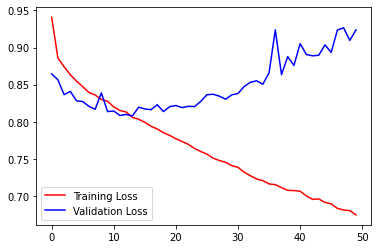

In [ ]:
loss=df_fnn['loss']
val_loss=df_fnn['val_loss']
epochs=range(len(loss)) # Get number of epochs
import matplotlib.pyplot as plt
# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend()
plt.show()

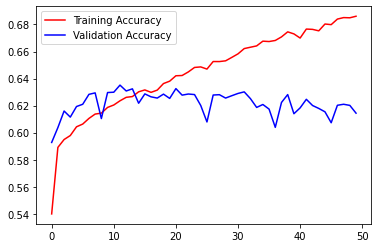

In [ ]:
acc=df_fnn['accuracy']
val_acc=df_fnn['val_accuracy']
epochs=range(len(acc)) # Get number of epochs

# Plot training and validation loss per epoch
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
re = model.evaluate(X_test_w2v, y_test_onehot)
print('Accuracy for 4a FNN is ' , re[1])

375/375 [==============================] - 1s 3ms/step - loss: 0.9238 - accuracy: 0.6144
Accuracy for 4a FNN is  0.6144166588783264


### b) concatenate the first 10 Word2Vec vectors for each review as the input feature (x = [WT 1,...,WT 10]) and train the neural network.

In [ ]:
def w2v_first10(text):
    text = text.split(" ")
    v = np.zeros((300*10))
    j = 0
    for i in text:
      if j == 10:
        break
      if i in wv:
        v[j*300:(j+1)*300] = wv[i]
        j += 1
    return np.array(v)

In [ ]:
w2v_first10('the product was going to be').shape

(3000,)

In [ ]:
X_train_w2v_first10 = np.array([w2v_first10(text) for text in X_train])
X_test_w2v_first10 = np.array([w2v_first10(text) for text in X_test])

In [ ]:
X_train_w2v_first10.shape

(48000, 3000)

In [ ]:
from keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, Conv2D, MaxPooling2D
from keras import Input
from tensorflow.keras.optimizers import Adam
# Build the model.
model = Sequential()

model.add(Input(shape=(X_train_w2v_first10.shape[1],)))
# model.add(Input(shape=(X_train_w2v.shape[1],)))
## Embedding(vocab_size, 300, input_length=X_train_w2v.shape[1])
## Input(shape=(X_train_w2v.shape[1],))
# model.add(Dense(128, input_dim=300, activation='relu'))
# model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.7))

model.add(Dense(3, activation='softmax'))
## Display the model summary.
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               300100    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 301,143
Trainable params: 301,143
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_results_5b = model.fit(X_train_w2v_first10, 
                             y_train_onehot, 
                             epochs=50, 
                             batch_size=64, 
                             callbacks = [callback],
                             validation_data=(X_test_w2v_first10, y_test_onehot))

Epoch 1/50
750/750 [==============================] - 5s 5ms/step - loss: 1.0360 - accuracy: 0.4390 - val_loss: 0.9780 - val_accuracy: 0.4938
Epoch 2/50
750/750 [==============================] - 2s 3ms/step - loss: 0.9958 - accuracy: 0.4815 - val_loss: 0.9672 - val_accuracy: 0.4978
Epoch 3/50
750/750 [==============================] - 2s 3ms/step - loss: 0.9788 - accuracy: 0.4983 - val_loss: 0.9547 - val_accuracy: 0.5135
Epoch 4/50
750/750 [==============================] - 2s 3ms/step - loss: 0.9696 - accuracy: 0.5027 - val_loss: 0.9487 - val_accuracy: 0.5148
Epoch 5/50
750/750 [==============================] - 2s 3ms/step - loss: 0.9593 - accuracy: 0.5131 - val_loss: 0.9484 - val_accuracy: 0.5155
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.9525 - accuracy: 0.5182 - val_loss: 0.9454 - val_accuracy: 0.5248
Epoch 7/50
750/750 [==============================] - 2s 3ms/step - loss: 0.9433 - accuracy: 0.5245 - val_loss: 0.9471 - val_accuracy: 0.5268
Epoch 

In [ ]:
re2 = model.evaluate(X_test_w2v_first10, y_test_onehot)
print('Accuracy for 4b FNN is ' , re2[1])

375/375 [==============================] - 1s 2ms/step - loss: 0.9422 - accuracy: 0.5296
Accuracy for 4b FNN is  0.5295833349227905


Ans: The model from 4a has better accuracy about 61%. The seconde is the model from simple model perceptron. 4b has the least accuracy model about 53%.

## 5. Recurrent Neural Networks

### (a) Train a simple RNN for sentiment analysis

In [ ]:
def w2v_first10(text):
    text = text.split(" ")
    n = len(text)
    d = []
    j = 0
    # t = np.zeros(300)
    for i in text:
        if j == 10:
            break
        if i in wv:
            print(i)
            j += 1
            d.append(wv[i])
    for k in range(j, 10):
        d.append(np.zeros(300))
    return np.array(d)

In [ ]:
def w2v_first20(text):
    text = text.split(" ")
    d = []
    j = 0
    # t = np.zeros(300)
    for i in text:
        if j == 20:
            break
        if i in wv:
            j += 1
            d.append(wv[i])
    for k in range(j, 20):
        d.append(np.zeros(300))
    return np.array(d)

In [ ]:
X_train_w2v_first20 = np.array([w2v_first20(text) for text in X_train])
X_test_w2v_first20 = np.array([w2v_first20(text) for text in X_test])

In [ ]:
import tensorflow as tf
X_train_w2v_first20 = np.asarray(X_train_w2v_first20).astype('float32')
train_tensor = tf.convert_to_tensor(X_train_w2v_first20)

X_test_w2v_first20 = np.asarray(X_test_w2v_first20).astype('float32')
test_tensor = tf.convert_to_tensor(X_test_w2v_first20)

In [ ]:
y_tensor1 = np.asarray(y_train).astype('float32')
y_tensor_train = tf.convert_to_tensor(y_tensor1)

y_tensor2 = np.asarray(y_test).astype('float32')
y_tensor_test = tf.convert_to_tensor(y_tensor2)

In [ ]:
test_tensor.shape

TensorShape([12000, 20, 300])

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Input(shape=(train_tensor.shape[1],train_tensor.shape[2])))
# model.add(Flatten())
# model.add(Embedding(train_tensor.shape[0], 300, input_length = 20))
model.add(SimpleRNN(20, return_sequences=True))
model.add(Flatten())
# model.add(Dense(10, activation = 'relu'))
model.add(Dense(3, activation='softmax'))
model.add(Dropout(0.4))
# model.build(input_shape=X_train_w2v_first20.shape)
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 20)            6420      
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 1203      
                                                                 
 dropout_2 (Dropout)         (None, 3)                 0         
                                                                 
Total params: 7,623
Trainable params: 7,623
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_results_5a = model.fit(train_tensor, 
                             y_train_onehot, 
                             epochs=50, 
                             batch_size=50, 
                            
                             validation_data=(test_tensor, y_test_onehot))

Epoch 1/50
960/960 [==============================] - 11s 10ms/step - loss: nan - accuracy: 0.3718 - val_loss: 1.0014 - val_accuracy: 0.4832
Epoch 2/50
960/960 [==============================] - 9s 9ms/step - loss: nan - accuracy: 0.4157 - val_loss: 0.9689 - val_accuracy: 0.5064
Epoch 3/50
960/960 [==============================] - 9s 10ms/step - loss: nan - accuracy: 0.4266 - val_loss: 0.9518 - val_accuracy: 0.5221
Epoch 4/50
960/960 [==============================] - 10s 10ms/step - loss: nan - accuracy: 0.4289 - val_loss: 0.9459 - val_accuracy: 0.5319
Epoch 5/50
960/960 [==============================] - 9s 10ms/step - loss: nan - accuracy: 0.4320 - val_loss: 0.9327 - val_accuracy: 0.5421
Epoch 6/50
960/960 [==============================] - 9s 10ms/step - loss: nan - accuracy: 0.4411 - val_loss: 0.9265 - val_accuracy: 0.5502
Epoch 7/50
960/960 [==============================] - 10s 10ms/step - loss: nan - accuracy: 0.4417 - val_loss: 0.9222 - val_accuracy: 0.5538
Epoch 8/50
960/960

In [ ]:
re3 = model.evaluate(test_tensor, y_test_onehot)
print('Accuracy for 5a simple RNN is ' , re3[1])

375/375 [==============================] - 2s 4ms/step - loss: 0.8859 - accuracy: 0.5811
Accuracy for 5a simple RNN is  0.581083357334137


Ans: I conclude that the RNN simple model have worse performance(about 58% accuracy) than the Feedforward neural network.

### 5b. GRU RNN

In [ ]:
from keras.layers import Embedding, SimpleRNN, Bidirectional, GRU
model = Sequential()
model.add(Input(shape=(train_tensor.shape[1],train_tensor.shape[2])))
# model.add(Flatten())
# model.add(Embedding(train_tensor.shape[0], 300, input_length = 20))
model.add(Bidirectional(GRU(20, return_sequences=True)))
model.add(Flatten())
# model.add(Dense(10, activation = 'relu'))
model.add(Dense(3, activation='softmax'))
model.add(Dropout(0.4))
# model.build(input_shape=X_train_w2v_first20.shape)
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20, 40)           38640     
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 800)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 2403      
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0         
                                                                 
Total params: 41,043
Trainable params: 41,043
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_results_5b = model.fit(train_tensor, 
                             y_train_onehot, 
                             epochs=75, 
                             batch_size=50, 
                            
                             validation_data=(test_tensor, y_test_onehot))

Epoch 1/75
960/960 [==============================] - 11s 7ms/step - loss: nan - accuracy: 0.3854 - val_loss: 1.0110 - val_accuracy: 0.4999
Epoch 2/75
960/960 [==============================] - 7s 7ms/step - loss: nan - accuracy: 0.4257 - val_loss: 0.9476 - val_accuracy: 0.5387
Epoch 3/75
960/960 [==============================] - 6s 6ms/step - loss: nan - accuracy: 0.4378 - val_loss: 0.9261 - val_accuracy: 0.5596
Epoch 4/75
960/960 [==============================] - 7s 7ms/step - loss: nan - accuracy: 0.4410 - val_loss: 0.9145 - val_accuracy: 0.5638
Epoch 5/75
960/960 [==============================] - 6s 6ms/step - loss: nan - accuracy: 0.4487 - val_loss: 0.9054 - val_accuracy: 0.5707
Epoch 6/75
960/960 [==============================] - 6s 6ms/step - loss: nan - accuracy: 0.4481 - val_loss: 0.9023 - val_accuracy: 0.5715
Epoch 7/75
960/960 [==============================] - 6s 6ms/step - loss: nan - accuracy: 0.4547 - val_loss: 0.8958 - val_accuracy: 0.5770
Epoch 8/75
960/960 [======

In [ ]:
re4 = model.evaluate(test_tensor, y_test_onehot)
print('Accuracy for 5b GRU  is ' , re4[1])

375/375 [==============================] - 2s 4ms/step - loss: 0.8286 - accuracy: 0.6189
Accuracy for 5b GRU  is  0.6189166903495789


### 5c) LSTM

In [ ]:
from keras.layers import Embedding, SimpleRNN, Bidirectional, GRU, LSTM
model = Sequential()
model.add(Input(shape=(train_tensor.shape[1],train_tensor.shape[2])))
# model.add(Flatten())
# model.add(Embedding(train_tensor.shape[0], 300, input_length = 20))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(Flatten())
# model.add(Dense(10, activation = 'relu'))
model.add(Dense(3, activation='softmax'))
model.add(Dropout(0.4))
# model.build(input_shape=X_train_w2v_first20.shape)
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 20, 40)           51360     
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 800)               0         
                                                                 
 dense_8 (Dense)             (None, 3)                 2403      
                                                                 
 dropout_4 (Dropout)         (None, 3)                 0         
                                                                 
Total params: 53,763
Trainable params: 53,763
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_results_5C = model.fit(train_tensor, 
                             y_train_onehot, 
                             epochs=75, 
                             batch_size=50, 
                            
                             validation_data=(test_tensor, y_test_onehot))

Epoch 1/75
960/960 [==============================] - 10s 7ms/step - loss: nan - accuracy: 0.3942 - val_loss: 0.9712 - val_accuracy: 0.5293
Epoch 2/75
960/960 [==============================] - 6s 7ms/step - loss: nan - accuracy: 0.4339 - val_loss: 0.9320 - val_accuracy: 0.5509
Epoch 3/75
960/960 [==============================] - 6s 7ms/step - loss: nan - accuracy: 0.4436 - val_loss: 0.9179 - val_accuracy: 0.5627
Epoch 4/75
960/960 [==============================] - 6s 7ms/step - loss: nan - accuracy: 0.4458 - val_loss: 0.9047 - val_accuracy: 0.5723
Epoch 5/75
960/960 [==============================] - 6s 7ms/step - loss: nan - accuracy: 0.4484 - val_loss: 0.8953 - val_accuracy: 0.5799
Epoch 6/75
960/960 [==============================] - 6s 6ms/step - loss: nan - accuracy: 0.4532 - val_loss: 0.8948 - val_accuracy: 0.5810
Epoch 7/75
960/960 [==============================] - 6s 7ms/step - loss: nan - accuracy: 0.4514 - val_loss: 0.8824 - val_accuracy: 0.5869
Epoch 8/75
960/960 [======

In [ ]:
re5 = model.evaluate(test_tensor, y_test_onehot)
print('Accuracy for 5c LSTM  is ' , re5[1])

375/375 [==============================] - 2s 3ms/step - loss: 0.8265 - accuracy: 0.6214
Accuracy for 5b GRU  is  0.6214166879653931


Ans: I conclude that GRU and LSTM layer has similar and high accuracy(62%) than any other models. Simple RNN modle has the least performance(58%)